In [ ]:
!pip install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 4.8 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323988104 sha256=6b082468a6abb6f6bc50c99263f17c6c7f5a2e8f6b275ed7998b81fb25279229
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba-ssm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from tqdm import tqdm

import math
import os
import urllib.request
from zipfile import ZipFile

from mamba_ssm import Mamba

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [ ]:
def pre_train(model, data_loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0
    loss_list = []
    average_loss = 0
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
        target = batch['target'].clone().detach().to(device=device, dtype=dtype)

        output = model(input_data)
        loss = criterion(output, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        total_loss += loss.item()
        loss_list.append(loss.item())
    return total_loss / len(data_loader), loss_list

In [ ]:
def fine_tune(model, data_loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0
    loss_list = []
    average_loss = 0
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
        target = batch['target'].clone().detach().to(device=device, dtype=dtype)

        output = model(input_data)
        loss = criterion(output[:, output.shape[1] - 1, 2],
                         target[:, output.shape[1] - 1, 2])

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        if loss.item() > 100:
          print(output[:, output.shape[1] - 1, 2])
          print(target[:, output.shape[1] - 1, 2])
          print(loss.item())

        total_loss += loss.item()
        loss_list.append(loss.item())
    return total_loss / len(data_loader), loss_list

In [ ]:
def backtest(model, data_loader, device, dtype):
    """
    def calculate_mape(y_true, y_pred):
      mape = torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
      return mape.cpu().detach().numpy()

    def calculate_alignment(y_true, y_pred, y_past):
      diff_t_p = torch.mean(y_true - y_past, dim=1)
      diff_p_p = torch.mean(y_pred - y_past, dim=1)
      count = 0
      for i in range(y_true.shape[0]):
        if diff_t_p[i] * diff_p_p[i] >= 0:
          count += 1
      return count * 100 / y_true.shape[0]

    total_mape = 0
    mape_list = []
    total_align = 0
    align_list = []
    pred = []
    real = []
    """

    model.eval()
    cash = 100000
    coins = 0
    last_value = 0
    returns = []

    with torch.no_grad():
      for i, batch in enumerate(data_loader):
          input_data = batch['sequences'].clone().detach().to(device=device, dtype=dtype)
          unaltered = batch['unaltered'].clone().detach().to(device=device, dtype=dtype).squeeze()
          manipulated = batch['target'].clone().detach().to(device=device, dtype=dtype)

          current_value = cash + coins * unaltered[0][0]

          output = model(input_data)
          if (output[:, output.shape[1] - 1, 2] < 0) and cash != 0:
            cash = short * unaltered[0][0]
            coins = cash / unaltered[0][0]
          elif (output[:, output.shape[1] - 1, 2] > 0) and coins != 0:
            cash = coins * unaltered[0][0]
            short = coins

          """mape = calculate_mape(target[:, output.shape[1] - 1, :output.shape[2] - 1],
                                last_output)

          num_align = calculate_alignment(target[:, output.shape[1] - 1, :output.shape[2] - 1])

          pred_price = torch.mean(last_output[:, :output.shape[2] - 1]).detach().cpu().numpy()
          real_price = torch.mean(target[:, :output.shape[2] - 1]).detach().cpu().numpy()
          pred.append(pred_price)
          real.append(real_price)

          total_mape += mape
          mape_list.append(mape)
          total_align += num_align
          align_list.append(num_align)"""

          if i == len(data_loader) - 1:
            cash += coins * unaltered[0][0]

          if i != 0:
            ret = current_value.item() / last_value.item() - 1
            returns.append(ret)

          last_value = current_value

    print(returns)
    returns = np.array(returns)
    avg_ret = np.mean(returns)
    std_ret = np.std(returns)
    print(avg_ret, std_ret)
    sharpe = (avg_ret - 0.0389/(354 * 24)) / std_ret
    #return total_mape / len(data_loader), mape_list, total_align / len(data_loader), pred, real
    return cash, sharpe

In [ ]:
import pandas as pd
import numpy as np

def create_sequences(data, columns, sequence_length=100):
    """
    Create sequences of length 'sequence_length' from time series data.

    Parameters:
    - data: pandas DataFrame, the time series data with rows as time steps
    - columns: list of str, the names of the 5 columns to use
    - sequence_length: int, the length of each sequence

    Returns:
    - sequences: numpy array of shape (num_sequences, sequence_length, 5)
    """

    # Select the 5 columns
    data_selected = data.loc[:, columns]

    # Convert to numpy array
    data_array = data_selected.values  # shape (num_time_steps, 5)
    data_array = data_array.astype(np.float64)
    manipulated = np.zeros((data_array.shape[0] - 1, 4))
    manipulated[:, 0] = data_array[1:, 0] / data_array[1:, 3]
    manipulated[:, 1] = data_array[1:, 1] / data_array[1:, 2]
    manipulated[:, 2] = np.array([data_array[i, 3] / data_array[i + 1, 3] for i in range(data_array.shape[0] - 1)])
    manipulated[:, 3] = data_array[1:, 4] + 1e-8
    manipulated = np.log(manipulated)
    data_array = data_array[1:, :]

    # Compute number of sequences
    num_time_steps = manipulated.shape[0]
    num_sequences = num_time_steps - sequence_length - 1

    # Generate sequences using a list comprehension for efficiency
    dataset = np.array([{'sequences': np.concatenate([manipulated[i:i + sequence_length], np.expand_dims(manipulated[i + sequence_length - 1], axis=0)]),
                         'target': manipulated[i:i + sequence_length + 1, :],
                         'unaltered': data_array[i + sequence_length - 1 : i + sequence_length + 1, :]} for i in range(num_sequences)])

    return dataset

In [ ]:
def sign_aware_mse_loss(predictions, targets, penalty=2.0):
    # Calculate absolute errors
    abs_errors = torch.square(predictions - targets)

    # Calculate the sign difference between predictions and targets
    sign_diff = torch.sign(predictions) != torch.sign(targets)

    # Apply penalty for sign mismatch
    sign_penalty = torch.where(sign_diff, penalty, 1.0)

    # Return the sign-aware MAE loss
    return torch.mean(abs_errors * sign_penalty)

In [ ]:
d_model = 4
state_size = 124  # Example state size
seq_len = 100  # Example sequence length
batch_size = 32  # Example batch size
conv_size = 2

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.utils as sk_utils

btc_data = pd.read_csv('BTC-Hourly.csv')

# Display the first few rows of the dataset
columns = ['open', 'high', 'low', 'close', 'Volume USD']

dataset = create_sequences(btc_data, columns)
train_dataset = dataset[:int(len(dataset) * 0.8)]
train_dataset = sk_utils.shuffle(train_dataset, random_state=33)
val_dataset = dataset[int(len(dataset) * 0.8):]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=d_model, # Model dimension d_model
    d_state=state_size,  # SSM state expansion factor
    d_conv=conv_size,    # Local convolution width
    expand=32,    # Block expansion factor
).to("cuda")

Epoch 1/5, Pre Train Loss: 2.4906


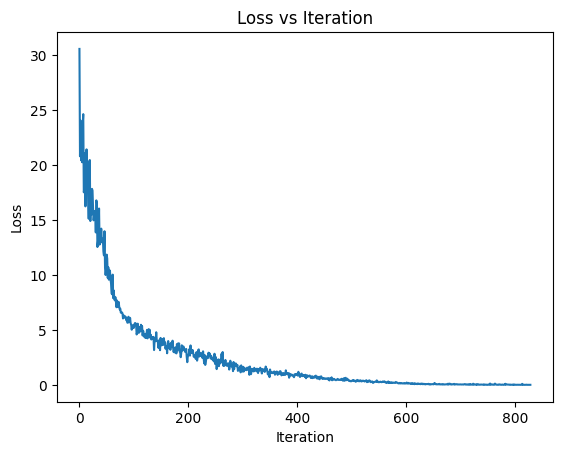

Epoch 2/5, Pre Train Loss: 0.0166


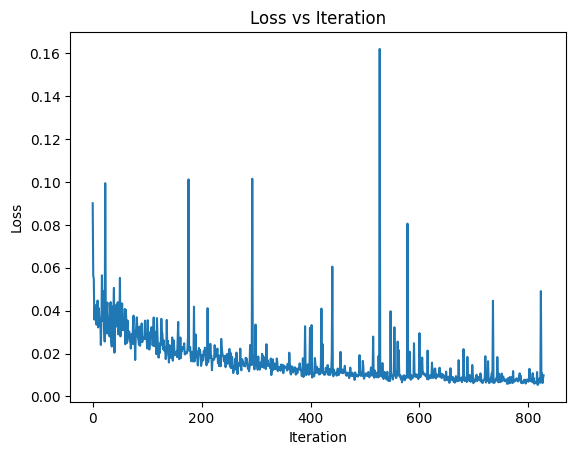

Epoch 3/5, Pre Train Loss: 0.0062


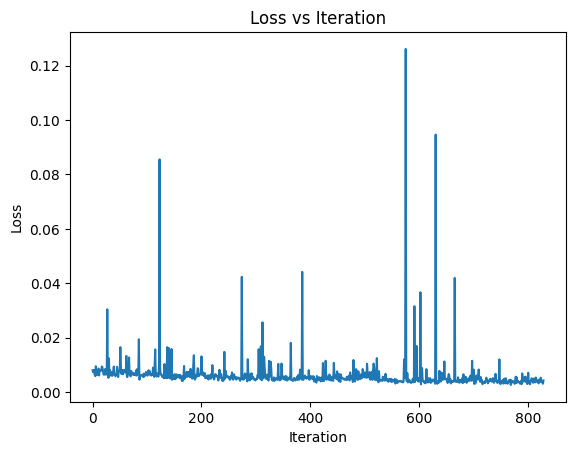

Epoch 4/5, Pre Train Loss: 0.0043


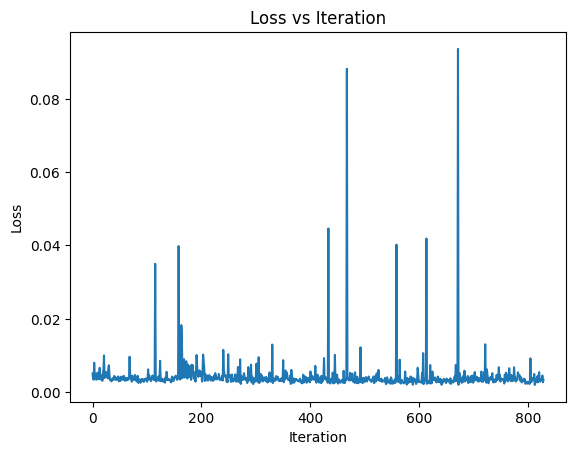

Epoch 5/5, Pre Train Loss: 0.0036


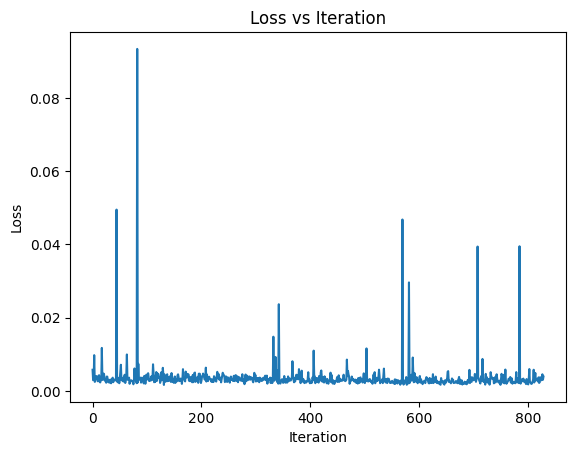

tensor([-7.5234e-03, -8.0581e-03, -1.6817e-02, -9.1643e-03, -1.8311e-02,
        -1.6820e+03, -5.9808e-03, -1.2405e-02, -1.0772e-02, -6.7104e-03,
        -8.5406e-03, -6.7296e-03, -2.0164e-02, -8.2979e-03, -7.4205e-03,
        -6.2977e-03, -2.9316e-03,  4.4007e-03, -6.3227e-03, -1.2921e-02,
        -2.6896e-03, -6.0490e-03, -8.1568e-03, -6.7880e-03, -1.0678e-02,
        -3.8384e-03,  2.4409e-02, -4.1392e-03, -4.2448e-03,  1.0512e-03,
        -1.8201e-02, -6.0079e-04], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 8.8354e-05, -4.3506e-03, -1.4694e-02,  1.3524e-03, -1.7036e-03,
         0.0000e+00, -3.7726e-03, -7.5876e-04, -2.6265e-03, -6.8973e-04,
         5.2403e-04, -4.2629e-03, -2.5550e-03,  9.9992e-04,  7.4357e-03,
         8.1570e-04,  1.7205e-02, -2.6548e-02, -1.3605e-02, -4.4238e-03,
         1.8403e-03,  2.5010e-03,  1.1192e-03,  1.2685e-03, -1.1887e-03,
         2.3588e-03,  1.2012e-03,  2.4056e-03,  9.3872e-03,  2.5569e-03,
        -1.3899e-02,  1.4637e-03], device='cu

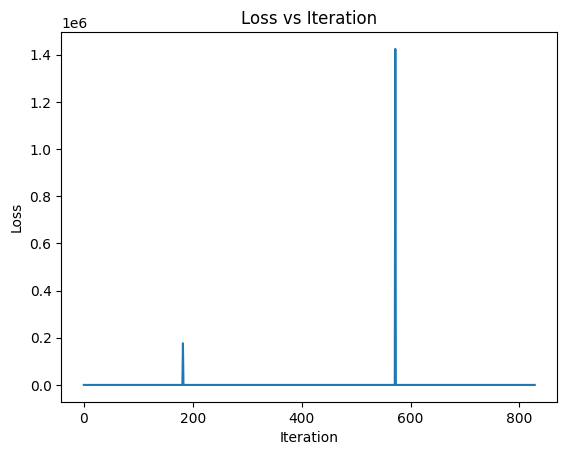

tensor([-1.2499e-01,  9.5839e-04, -1.3685e-03, -4.0990e-03, -1.0716e-01,
        -1.0273e-01, -1.0231e-01, -1.0023e-01, -1.0481e-01, -1.0177e-01,
        -1.0283e-01, -1.0327e-01, -1.0065e-01, -9.5836e-02,  1.2037e-03,
         7.7168e+01, -9.7351e-02, -9.7517e-02, -2.1066e-02, -4.9770e-03,
        -8.9632e-03, -1.8122e-02, -1.0704e-01, -1.0841e-01, -1.0181e-01,
        -1.0706e-01,  2.5825e-03, -7.3771e-03, -1.0726e-01, -1.1228e-03,
        -5.7667e-04, -4.1555e-02], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0136,  0.0033,  0.0034,  0.0114, -0.0122,  0.0030,  0.0051,  0.0127,
         0.0019, -0.0018,  0.0005,  0.0020, -0.0015, -0.0010,  0.0053,  0.0000,
        -0.0055,  0.0005, -0.0104,  0.0028,  0.0023, -0.0065, -0.0042,  0.0022,
        -0.0027, -0.0015, -0.0086,  0.0014, -0.0037, -0.0024,  0.0026, -0.0323],
       device='cuda:0')
372.1884765625
tensor([ 8.6701e-03,  7.3481e-03,  1.0918e-02,  6.6826e-03,  5.1644e-03,
         5.5145e-03,  1.1534e-02,  7.6797e-03, -2.

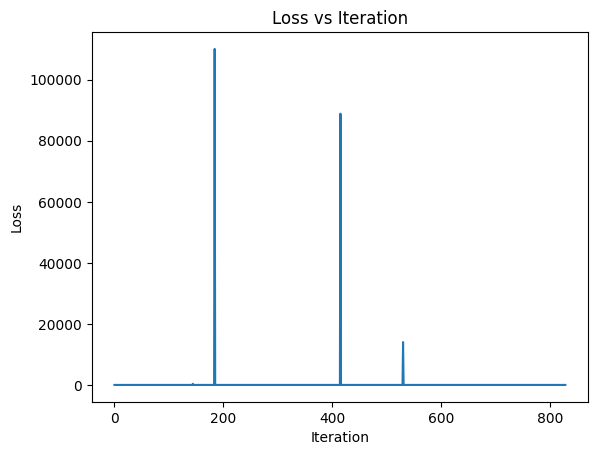

tensor([-1.1763e-03, -2.1422e-03,  2.4138e-04, -7.9370e+01,  1.2411e-03,
        -6.6871e-04,  2.0462e-03,  3.7809e-03, -8.7268e-04,  2.6276e-03,
        -1.3912e-02, -7.1347e-03,  6.5553e-03, -1.1431e-02, -3.8429e-03,
         1.4944e-03,  3.0720e-03, -1.8866e-03,  1.0618e-03, -5.4310e-03,
        -1.3512e-03, -1.1866e-02, -2.3601e-03, -1.5245e-03,  9.8936e-04,
        -5.2250e-03,  1.1953e-02, -1.4112e-04,  1.1898e-02, -1.2610e-02,
        -1.2423e-03, -1.5443e-03], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0018, -0.0077,  0.0012,  0.0000,  0.0012, -0.0014,  0.0062,  0.0067,
        -0.0013,  0.0024, -0.0209, -0.0071,  0.0071, -0.0123, -0.0025,  0.0009,
         0.0054, -0.0033, -0.0002, -0.0139, -0.0015, -0.0157, -0.0036, -0.0044,
         0.0025, -0.0066,  0.0240,  0.0045,  0.0192, -0.0114, -0.0033, -0.0029],
       device='cuda:0')
393.7283935546875
tensor([ 2.0967e-03, -6.5666e-03,  1.6423e-03,  1.5981e-03, -1.1334e-02,
         3.4749e-03,  1.0022e-04, -1.5944e-03, 

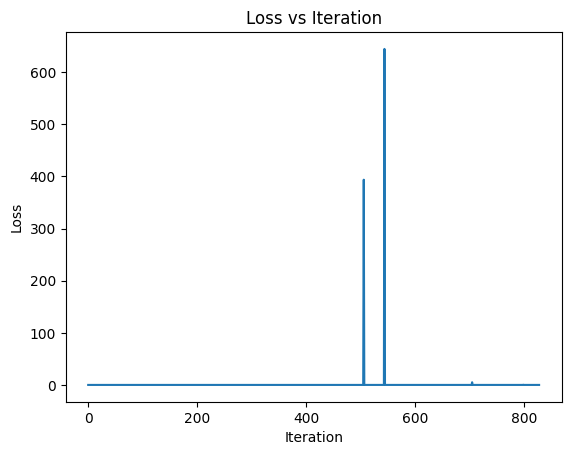

tensor([ 9.2476e-05,  6.9475e-03,  8.2700e-03, -3.5080e-03, -1.7944e-03,
        -2.5200e-05,  1.9550e-02,  5.2891e-03, -2.3422e-03,  1.6103e-02,
        -1.4749e-02,  2.6990e-03,  4.2439e-03, -1.5684e-03, -2.8628e-03,
        -1.4782e-02, -1.1068e-02, -8.5285e+01, -8.1303e-04,  1.1294e-02,
         1.7941e-02,  1.4644e-03, -6.4492e-04, -2.7211e-03, -1.4153e-03,
         1.2088e-03, -2.9580e-03,  8.5142e-04,  1.3925e-02,  4.8380e-05,
         1.7179e-03, -3.2461e-03], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-2.8043e-03,  3.3100e-03,  6.2253e-03, -4.9041e-03,  1.9958e-04,
        -1.2149e-03,  1.1967e-02,  4.9093e-03,  6.9094e-05,  1.3445e-02,
        -2.7063e-02,  5.3946e-03,  8.5940e-04,  1.9497e-03, -1.1147e-02,
        -1.4970e-02, -8.4997e-03,  0.0000e+00, -6.5603e-04,  1.0797e-02,
         1.0988e-02,  9.6187e-04, -2.0888e-03,  1.7398e-04, -6.2927e-04,
        -4.2390e-03, -3.3651e-04,  1.6287e-03,  2.6255e-02, -2.2881e-03,
         9.5042e-04, -9.1442e-03], device='cu

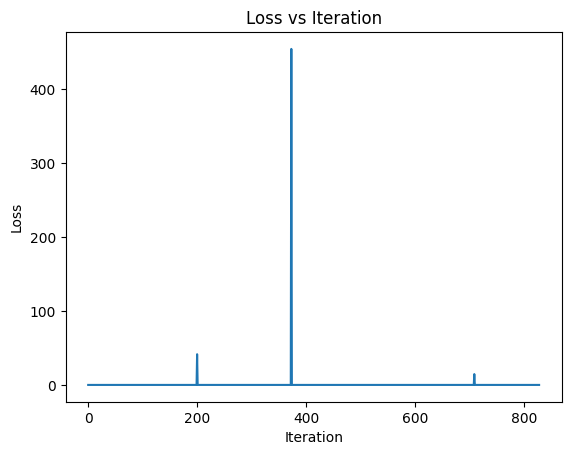

Epoch 5/5, Fine Tune Loss: 0.0006


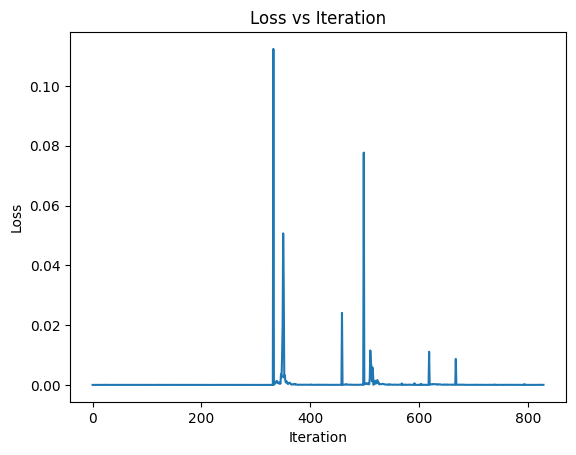

In [ ]:
# Training loop
num_epochs = 5
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_epochs = []
for epoch in range(num_epochs):
    train_loss, loss_list = pre_train(model, train_loader, optimizer, criterion, device, dtype=torch.float)
    print(f"Epoch {epoch+1}/{num_epochs}, Pre Train Loss: {train_loss:.4f}")
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()
    loss_epochs.append(train_loss)

optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = sign_aware_mse_loss
num_epochs = 5
loss_epochs = []
for epoch in range(num_epochs):
    train_loss, loss_list = fine_tune(model, train_loader, optimizer, criterion, device, dtype=torch.float)
    print(f"Epoch {epoch+1}/{num_epochs}, Fine Tune Loss: {train_loss:.4f}")
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iteration')
    plt.show()
    loss_epochs.append(train_loss)

torch.save(model, 'mamba_crypto_min.pt')


In [ ]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=0d8e69557cfc7fa4e9733d5afdd4149b0d5d19a894be5f9abf9342e1489e4d20
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover

model = torch.load('mamba_crypto_min.pt')

columns = ['Open', 'High', 'Low', 'Close', 'Volume']

class MambaPredict(Strategy):

    def init(self):
        self.model = model
        self.data_columns = create_sequences(btc_data, columns)
        self.i = 0

    def next(self):
        if len(self.data.Close) >= 100:
            input_data = torch.from_numpy(self.data_columns[self.i]['sequences']).unsqueeze(0).float().to(device=device, dtype=torch.float)

            output = model(input_data)
            if (output[:, output.shape[1] - 1, 2] < 0):
                self.position.close()
                self.buy()
            elif (output[:, output.shape[1] - 1, 2] > 0):
                self.position.close()
                self.sell()
        self.i += 1

<ipython-input-82-8ddff194e255>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mamba_crypto_min.pt')


In [ ]:
from backtesting import Backtest

btc_data = btc_data.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'Volume BTC': 'Volume'  # Rename Volume BTC to Volume
})

btc_data = btc_data[:int(len(btc_data) * 0.8)]

bt = Backtest(btc_data, MambaPredict, cash=1000000, commission=.002)
stats = bt.run()
stats

<ipython-input-84-16cf948b4c05>:13: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(btc_data, MambaPredict, cash=1000000, commission=.002)


IndexError: index 26505 is out of bounds for axis 0 with size 26505